<a href="https://colab.research.google.com/github/luuloi/GWAS_Introduction_2023/blob/main/06_PolygenicRiskScore.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0. SETUP WORKING ENVIRONMENT

## Download Necessary Pakage

In [1]:
# Install using pip

!pip install rpy2==3.5.1
!pip install -q condacolab
!pip install gdown

In [2]:
# Ignore rpy2's warnings

import rpy2
import warnings
from rpy2.rinterface import RRuntimeWarning

warnings.filterwarnings("ignore", category=RRuntimeWarning)

In [3]:
# Initialize conda

import condacolab
condacolab.install()

✨🍰✨ Everything looks OK!


## Set up R environment by installing required packages

In [4]:
# activate R magic
%load_ext rpy2.ipython

In [ ]:
%%R
install.packages("ggplot2")
library(ggplot2)

## Install Plink Package

In [ ]:
# Install plink

!conda install -c bioconda plink

## Prepare Data

In [6]:
%%bash

# Create folder to store neccesary data
mkdir data
mkdir -p data/base
mkdir -p data/target

mkdir: cannot create directory ‘data’: File exists


In [ ]:
%%bash
wget -O data/base/Height.gwas.txt.gz https://raw.githubusercontent.com/luuloi/GWAS_Introduction_2023/main/data/Height.gwas.txt.gz
gdown -O data/target/EUR.zip https://drive.google.com/uc?id=1uhJR_3sn7RA8U5iYQbcmTp6vFdQiF4F2&export=download

In [8]:
!unzip data/target/EUR.zip -d data/target

Archive:  data/target/EUR.zip
replace data/target/EUR.bed? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: data/target/EUR.bed     
  inflating: data/target/EUR.bim     
  inflating: data/target/EUR.cov     
  inflating: data/target/EUR.fam     
  inflating: data/target/EUR.height  


## Have a look into our data

**Base data**

Base data (GWAS), consisting of summary statistics of genotype-phenotype associations at genetic variants (hereafter SNPs) genome-wide, typically made available online in text format by the investigators who performed the GWAS

In [9]:
!zcat data/base/Height.gwas.txt.gz | head

CHR	BP	SNP	A1	A2	N	SE	P	OR	INFO	MAF
1	756604	rs3131962	A	G	388028	0.00301666	0.483171	0.997886915712657	0.890557941364774	0.369389592764921
1	768448	rs12562034	A	G	388028	0.00329472	0.834808	1.00068731609353	0.895893511351165	0.336845754096289
1	779322	rs4040617	G	A	388028	0.00303344	0.42897	0.997603556067569	0.897508290615237	0.377368010940814
1	801536	rs79373928	G	T	388028	0.00841324	0.808999	1.00203569922793	0.908962856432993	0.483212245374095
1	808631	rs11240779	G	A	388028	0.00242821	0.590265	1.00130832511154	0.893212523690488	0.450409558999587
1	809876	rs57181708	G	A	388028	0.00336785	0.71475	1.00123165786833	0.923557624081969	0.499743932656759
1	835499	rs4422948	G	A	388028	0.0023758	0.710884	0.999119752645202	0.906437735120596	0.481016005816168
1	838555	rs4970383	A	C	388028	0.00235773	0.150993	0.996619945289758	0.907716506801574	0.327164029672754
1	840753	rs4970382	C	T	388028	0.00207377	0.199967	0.99734567895614	0.914602590137255	0.498936220426316


**Target data**

Consisting of genotypes, and usually also phenotypes, in individuals from a sample to which the researchers performing the PRS analysis have access (often not publicly available), which should be independent of the GWAS sample.

In [10]:
!cat data/target/EUR.height | head

FID	IID	Height
HG00096	HG00096	169.132168767547
HG00097	HG00097	171.256258630279
HG00099	HG00099	171.534379938588
HG00101	HG00101	169.850176470551
HG00102	HG00102	172.788360878389
HG00103	HG00103	169.862973824923
HG00105	HG00105	168.939248611414
HG00107	HG00107	168.972346393861
HG00108	HG00108	171.311736719186


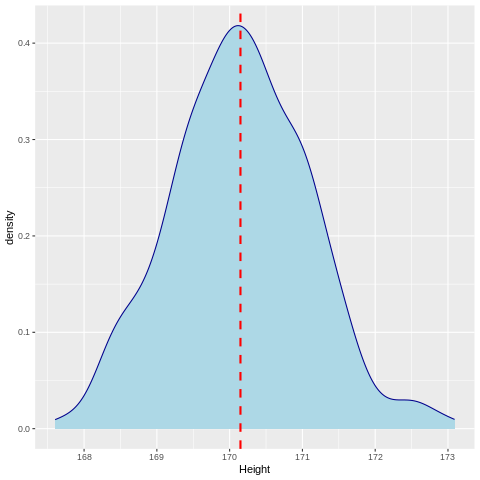

In [16]:
%%R
# Import data
pheno_height <- read.table("data/target/EUR.height", header=T)

p <- ggplot(pheno_height, aes(x=Height)) +
    geom_density(color="darkblue", fill="lightblue")
p

# Add mean line
p + geom_vline(aes(xintercept=mean(Height)),
               color="red", linetype="dashed", size=1)

# 1. QUALITY CONTROL

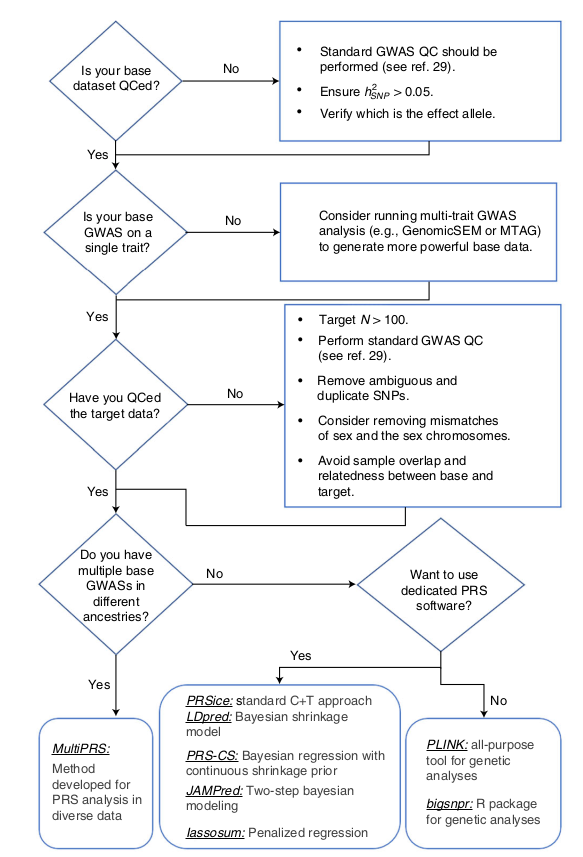

## A. QC of Base Data

**Reading the base data file**

In [5]:
!zcat data/base/Height.gwas.txt.gz | head

CHR	BP	SNP	A1	A2	N	SE	P	OR	INFO	MAF
1	756604	rs3131962	A	G	388028	0.00301666	0.483171	0.997886915712657	0.890557941364774	0.369389592764921
1	768448	rs12562034	A	G	388028	0.00329472	0.834808	1.00068731609353	0.895893511351165	0.336845754096289
1	779322	rs4040617	G	A	388028	0.00303344	0.42897	0.997603556067569	0.897508290615237	0.377368010940814
1	801536	rs79373928	G	T	388028	0.00841324	0.808999	1.00203569922793	0.908962856432993	0.483212245374095
1	808631	rs11240779	G	A	388028	0.00242821	0.590265	1.00130832511154	0.893212523690488	0.450409558999587
1	809876	rs57181708	G	A	388028	0.00336785	0.71475	1.00123165786833	0.923557624081969	0.499743932656759
1	835499	rs4422948	G	A	388028	0.0023758	0.710884	0.999119752645202	0.906437735120596	0.481016005816168
1	838555	rs4970383	A	C	388028	0.00235773	0.150993	0.996619945289758	0.907716506801574	0.327164029672754
1	840753	rs4970382	C	T	388028	0.00207377	0.199967	0.99734567895614	0.914602590137255	0.498936220426316


* **CHR**: The chromosome in which the SNP resides
* **BP**: Chromosomal co-ordinate of the SNP
* **SNP**: SNP ID, usually in the form of rs-ID
* **A1**: The effect allele of the SNP
* **A2**: The non-effect allele of the SNP
* **N**: Number of samples used to obtain the effect size estimate
* **SE**: The standard error (SE) of the effect size esimate
* **P**: The P-value of association between the SNP genotypes and the base phenotype
* **OR**: The effect size estimate of the SNP, if the outcome is binary/case-control. If the outcome is continuous or treated as continuous then this will usually be BETA
* **INFO**: The imputation information score
* **MAF**: The minor allele frequency (MAF) of the SNP



### QC checklist: Base data

**i. Heritability check**

Recommend that PRS analyses are performed on base data with a chip-heritability estimate 	h^2 SNP > 0.05


**ii. Effect allele**

It is important to know which allele is the effect allele and which is the non-effect allele for PRS association results to be in the correct direction.

**iii. Genome build**

- hg19
- hg38
- ...

**iv. Standard GWAS QC**

In [22]:
%%bash
mkdir QC
mkdir -p QC/base
mkdir -p QC/target

mkdir: cannot create directory ‘QC’: File exists


In [23]:
%%bash

# Filter by MAF, INFO
## MAF > 0.01 & INFO > 0.8

zcat data/base/Height.gwas.txt.gz |\
awk 'NR==1 || ($11 > 0.01) && ($10 > 0.8) {print}' |\
gzip  > QC/base/Height.gz

**v. Mismatching SNPs**

**vi. Duplicates SNPs**

In [8]:
%%bash
# Remove duplicate SNPs

zcat QC/base/Height.gz |\
awk '{seen[$3]++; if(seen[$3]==1){ print}}' |\
gzip - > QC/base/Height.nodup.gz

**vii. Ambigous SNPs**

In [9]:
%%bash

zcat QC/base/Height.nodup.gz |\
awk '!( ($4=="A" && $5=="T") || \
        ($4=="T" && $5=="A") || \
        ($4=="G" && $5=="C") || \
        ($4=="C" && $5=="G")) {print}' |\
    gzip > QC/base/Height.QC.gz

**vii. Sex chromosomes**

**viii. Relatedness**

## B. QC of Target Data

### QC checklist: Target data

**i. Sample size**

The target data suitable to perform PRS analyses should have at least 100 individuals. The sample size of our data here is 503 individuals.

In [10]:
%%bash
# Check the sample size
cat data/target/EUR.fam | wc -l


0


cat: data/target/EUR.fam: No such file or directory


**ii. Genome build**

**iii. Standard GWAS QC**

In [13]:
%%bash

plink \
    --bfile data/target/EUR \
    --maf 0.01 \
    --hwe 1e-6 \
    --geno 0.01 \
    --mind 0.01 \
    --write-snplist \
    --make-just-fam \
    --out QC/target/EUR.QC

PLINK v1.90b6.21 64-bit (19 Oct 2020)          www.cog-genomics.org/plink/1.9/
(C) 2005-2020 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to QC/target/EUR.QC.log.
Options in effect:
  --bfile data/target/EUR
  --geno 0.01
  --hwe 1e-6
  --maf 0.01
  --make-just-fam
  --mind 0.01
  --out QC/target/EUR.QC
  --write-snplist

12982 MB RAM detected; reserving 6491 MB for main workspace.
551892 variants loaded from .bim file.
503 people (240 males, 263 females) loaded from .fam.
14 people removed due to missing genotype data (--mind).
IDs written to QC/target/EUR.QC.irem .
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 489 founders and 0 nonfounders present.
Calculating allele frequencies... 0%1%2%3%4%5%6%7%8%9%10%11%12%13%14%15%16%17%18%19%20%21%22%23%24%25%26%27%28%29%30%31%32%33%34%35%36%37%38%39%40%41%42%4

commands treat these as missing.
chromosome.  You may want to use a less stringent --hwe p-value threshold for X
chromosome variants.


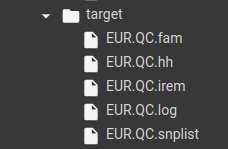

Some files are needed in the QC/target folder for the below processing:

In [14]:
%%bash

cp data/target/EUR* QC/target/

Samples with extreme heterozygosity are typically removed prior to downstream analyses.

This will generate two files 1) EUR.QC.prune.in and 2) EUR.QC.prune.out. All SNPs within EUR.QC.prune.in have a pairwise r2\<0.25

In [15]:
%%bash
# Perform pruning to remove highly correlated SNPs

plink \
    --bfile QC/target/EUR \
    --keep QC/target/EUR.QC.fam \
    --extract QC/target/EUR.QC.snplist \
    --indep-pairwise 200 50 0.25 \
    --out QC/target/EUR.QC

PLINK v1.90b6.21 64-bit (19 Oct 2020)          www.cog-genomics.org/plink/1.9/
(C) 2005-2020 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to QC/target/EUR.QC.log.
Options in effect:
  --bfile QC/target/EUR
  --extract QC/target/EUR.QC.snplist
  --indep-pairwise 200 50 0.25
  --keep QC/target/EUR.QC.fam
  --out QC/target/EUR.QC

12982 MB RAM detected; reserving 6491 MB for main workspace.
551892 variants loaded from .bim file.
503 people (240 males, 263 females) loaded from .fam.
--extract: 540534 variants remaining.
--keep: 489 people remaining.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 489 founders and 0 nonfounders present.
Calculating allele frequencies... 0%1%2%3%4%5%6%7%8%9%10%11%12%13%14%15%16%17%18%19%20%21%22%23%24%25%26%27%28%29%30%31%32%33%34%35%36%37%38%39%40%41%42%43%44%45%46%

commands treat these as missing.


Heterozygosity rates can then be computed using plink:

In [ ]:
%%bash

plink \
    --bfile QC/target/EUR \
    --extract QC/target/EUR.QC.prune.in \
    --keep QC/target/EUR.QC.fam \
    --het \
    --out QC/target/EUR.QC

In [ ]:
%%bash

cat QC/target/EUR.QC.het | head

In [ ]:
%%R
# Read in the EUR.het file, specify it has header
dat <- read.table("QC/target/EUR.QC.het", header=T)

# Calculate the mean
m <- mean(dat$F)

# Calculate the SD
s <- sd(dat$F)

# Get any samples with F coefficient within 3 SD of the population mean
valid <- subset(dat, F <= m+3*s & F >= m-3*s)

# print FID and IID for valid samples
write.table(valid[,c(1,2)], "QC/target/EUR.valid.sample", quote=F, row.names=F)

**iv. Ambiguous SNPs**

**v. Mismatching SNPs**

1. Load the bim file, the summary statistic and the QC SNP list into R

In [ ]:
%%R
# Read in bim file
bim <- read.table("data/target/EUR.bim")
colnames(bim) <- c("CHR", "SNP", "CM", "BP", "B.A1", "B.A2")

# Read in QCed SNPs
qc <- read.table("QC/target/EUR.QC.snplist", header = F, stringsAsFactors = F)

# Read in the GWAS data
height <-
    read.table(gzfile("QC/base/Height.QC.gz"),
            header = T,
            stringsAsFactors = F,
            sep="\t")

# Change all alleles to upper case for easy comparison
height$A1 <- toupper(height$A1)
height$A2 <- toupper(height$A2)
bim$B.A1 <- toupper(bim$B.A1)
bim$B.A2 <- toupper(bim$B.A2)

In [ ]:
%%R
head(bim)

2. Identify SNPs that require strand flipping

In [ ]:
%%R

# Merge summary statistic with target
info <- merge(bim, height, by = c("SNP", "CHR", "BP"))

# Filter QCed SNPs
info <- info[info$SNP %in% qc$V1,]

# Function for finding the complementary allele
complement <- function(x) {
    switch (
        x,
        "A" = "T",
        "C" = "G",
        "T" = "A",
        "G" = "C",
        return(NA)
    )
}

# Get SNPs that have the same alleles across base and target
info.match <- subset(info, A1 == B.A1 & A2 == B.A2)

# Identify SNPs that are complementary between base and target
info$C.A1 <- sapply(info$B.A1, complement)
info$C.A2 <- sapply(info$B.A2, complement)
info.complement <- subset(info, A1 == C.A1 & A2 == C.A2)

# Update the complementary alleles in the bim file
# This allow us to match the allele in subsequent analysis
complement.snps <- bim$SNP %in% info.complement$SNP
bim[complement.snps,]$B.A1 <-
    sapply(bim[complement.snps,]$B.A1, complement)
bim[complement.snps,]$B.A2 <-
    sapply(bim[complement.snps,]$B.A2, complement)

3. Identify SNPs that require recoding in the target (to ensure the coding allele in the target data is the effective allele in the base summary statistic)

In [ ]:
%%R
# identify SNPs that need recoding
info.recode <- subset(info, A1 == B.A2 & A2 == B.A1)

# Update the recode SNPs
recode.snps <- bim$SNP %in% info.recode$SNP
tmp <- bim[recode.snps,]$B.A1
bim[recode.snps,]$B.A1 <- bim[recode.snps,]$B.A2
bim[recode.snps,]$B.A2 <- tmp

# identify SNPs that need recoding & complement
info.crecode <- subset(info, A1 == C.A2 & A2 == C.A1)

# Update the recode + strand flip SNPs
com.snps <- bim$SNP %in% info.crecode$SNP
tmp <- bim[com.snps,]$B.A1
bim[com.snps,]$B.A1 <- as.character(sapply(bim[com.snps,]$B.A2, complement))
bim[com.snps,]$B.A2 <- as.character(sapply(tmp, complement))

# Output updated bim file
write.table(
    bim[,c("SNP", "B.A1")],
    "QC/target/EUR.a1",
    quote = F,
    row.names = F,
    col.names = F,
    sep="\t"
)

In [ ]:
!cat QC/target/EUR.a1 | head

4. Identify SNPs that have different allele in base and target (usually due to difference in genome build or Indel)

In [ ]:
%%R
mismatch <-
    bim$SNP[!(bim$SNP %in% info.match$SNP |
                bim$SNP %in% info.complement$SNP |
                bim$SNP %in% info.recode$SNP |
                bim$SNP %in% info.crecode$SNP)]
write.table(
    mismatch,
    "QC/target/EUR.mismatch",
    quote = F,
    row.names = F,
    col.names = F
)

In [ ]:
%%R
head(mismatch)

**vi. Duplicate SNPs**

**vii. Sex Chromosomes**

In [ ]:
%%bash

plink \
    --bfile QC/target/EUR \
    --extract QC/target/EUR.QC.prune.in \
    --keep QC/target/EUR.valid.sample \
    --check-sex \
    --out QC/target/EUR.QC

This will generate a file called EUR.QC.sexcheck containing the F-statistics for each individual. Individuals are typically called as being biologically male if the F-statistic is > 0.8 and biologically female if F < 0.2.

In [ ]:
%%R
# Read in file
valid <- read.table("QC/target/EUR.valid.sample", header=T)
dat <- read.table("QC/target/EUR.QC.sexcheck", header=T)
valid <- subset(dat, STATUS=="OK" & FID %in% valid$FID)
write.table(valid[,c("FID", "IID")], "QC/target/EUR.QC.valid", row.names=F, col.names=F, sep="\t", quote=F)

**viii. Sample overlap**

**ix. Relatedness**

In [ ]:
%%bash

plink \
    --bfile QC/target/EUR \
    --extract QC/target/EUR.QC.prune.in \
    --keep QC/target/EUR.QC.valid \
    --rel-cutoff 0.125 \
    --out QC/target/EUR.QC

## Generate final QC'ed target data file

In [ ]:
%%bash

plink \
    --bfile QC/target/EUR \
    --make-bed \
    --keep QC/target/EUR.QC.rel.id \
    --out QC/target/EUR.QC \
    --extract QC/target/EUR.QC.snplist \
    --exclude QC/target/EUR.mismatch \
    --a1-allele QC/target/EUR.a1

# 2. Calculating and analysing PRS using PLINK

In [ ]:
mkdir PRS

## Update Effect Size

In [ ]:
%%R

dat <- read.table(gzfile("QC/base/Height.QC.gz"), header=T)
dat$BETA <- log(dat$OR)
write.table(dat, "PRS/Height.QC.Transformed", quote=F, row.names=F)

## Clumping

This will generate EUR.clumped, containing the index SNPs after clumping is performed.

In [ ]:
%%bash

plink \
    --bfile QC/target/EUR.QC \
    --clump-p1 1 \
    --clump-r2 0.1 \
    --clump-kb 250 \
    --clump PRS/Height.QC.Transformed \
    --clump-snp-field SNP \
    --clump-field P \
    --out PRS/EUR

We can extract the index SNP ID by performing the following command:

In [ ]:
%%bash

awk 'NR!=1{print $3}' PRS/EUR.clumped >  PRS/EUR.valid.snp

## Generate PRS

plink provides a convenient function --score and --q-score-range for calculating polygenic scores.

1. The base data file: Height.QC.Transformed

2. A file containing SNP IDs and their corresponding P-values $3 because SNP ID is located in the third column; $8 because the P-value is located in the eighth column

In [ ]:
%%bash
awk '{print $3,$8}' PRS/Height.QC.Transformed > PRS/SNP.pvalue

3. A file containing the different P-value thresholds for inclusion of SNPs in the PRS. Here calculate PRS corresponding to a few thresholds for illustration purposes:

In [ ]:
%%bash

echo "0.001 0 0.001" > PRS/range_list
echo "0.05 0 0.05" >> PRS/range_list
echo "0.1 0 0.1" >> PRS/range_list
echo "0.2 0 0.2" >> PRS/range_list
echo "0.3 0 0.3" >> PRS/range_list
echo "0.4 0 0.4" >> PRS/range_list
echo "0.5 0 0.5" >> PRS/range_list

We can then calculate the PRS with the following plink command:

In [ ]:
%%bash

plink \
    --bfile QC/target/EUR.QC \
    --score PRS/Height.QC.Transformed 3 4 12 header \
    --q-score-range PRS/range_list PRS/SNP.pvalue \
    --extract PRS/EUR.valid.snp \
    --out PRS/EUR

The above command and range_list will generate 7 files:

* EUR.0.5.profile
* EUR.0.4.profile
* EUR.0.3.profile
* EUR.0.2.profile
* EUR.0.1.profile
* EUR.0.05.profile
* EUR.0.001.profile

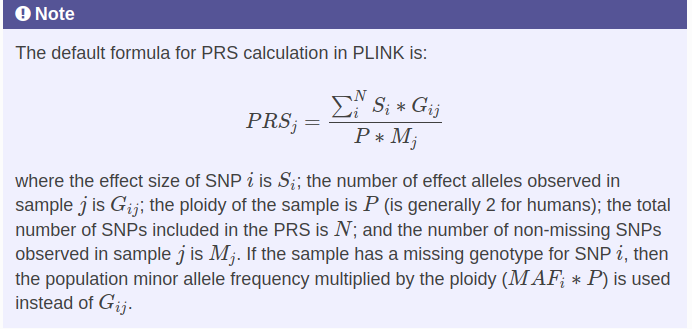

## Accounting for Population Stratification


Population structure is the principal source of confounding in GWAS and is usually accounted for by incorporating principal components (PCs) as covariates. We can incorporate PCs into our PRS analysis to account for population stratification.

Again, we can calculate the PCs using `plink`:

In [ ]:
%%bash

# First, we need to perform prunning
plink \
    --bfile QC/target/EUR.QC \
    --indep-pairwise 200 50 0.25 \
    --out PRS/EUR

# Then we calculate the first 6 PCs
plink \
    --bfile QC/target/EUR.QC \
    --extract PRS/EUR.prune.in \
    --pca 6 \
    --out PRS/EUR

# Finding the "best-fit" PRS

In [ ]:
%%R

p.threshold <- c(0.001,0.05,0.1,0.2,0.3,0.4,0.5)

# Read in the phenotype file
phenotype <- read.table("data/target/EUR.height", header=T)

# Read in the PCs
pcs <- read.table("PRS/EUR.eigenvec", header=F)

# The default output from plink does not include a header
# To make things simple, we will add the appropriate headers
# (1:6 because there are 6 PCs)
colnames(pcs) <- c("FID", "IID", paste0("PC",1:6))

# Read in the covariates (here, it is sex)
covariate <- read.table("data/target/EUR.cov", header=T)

# Now merge the files
pheno <- merge(merge(phenotype, covariate, by=c("FID", "IID")), pcs, by=c("FID","IID"))

# We can then calculate the null model (model with PRS) using a linear regression
# (as height is quantitative)
null.model <- lm(Height~., data=pheno[,!colnames(pheno)%in%c("FID","IID")])

# And the R2 of the null model is
null.r2 <- summary(null.model)$r.squared
prs.result <- NULL
for(i in p.threshold){
    # Go through each p-value threshold
    prs <- read.table(paste0("PRS/EUR.",i,".profile"), header=T)
    # Merge the prs with the phenotype matrix
    # We only want the FID, IID and PRS from the PRS file, therefore we only select the
    # relevant columns
    pheno.prs <- merge(pheno, prs[,c("FID","IID", "SCORE")], by=c("FID", "IID"))
    # Now perform a linear regression on Height with PRS and the covariates
    # ignoring the FID and IID from our model
    model <- lm(Height~., data=pheno.prs[,!colnames(pheno.prs)%in%c("FID","IID")])
    # model R2 is obtained as
    model.r2 <- summary(model)$r.squared
    # R2 of PRS is simply calculated as the model R2 minus the null R2
    prs.r2 <- model.r2-null.r2
    # We can also obtain the coeffcient and p-value of association of PRS as follow
    prs.coef <- summary(model)$coeff["SCORE",]
    prs.beta <- as.numeric(prs.coef[1])
    prs.se <- as.numeric(prs.coef[2])
    prs.p <- as.numeric(prs.coef[4])
    # We can then store the results
    prs.result <- rbind(prs.result, data.frame(Threshold=i, R2=prs.r2, P=prs.p, BETA=prs.beta,SE=prs.se))
}
# Best result is:
prs.result[which.max(prs.result$R2),]

In [ ]:
%%R
head(data.frame(prs.result))

# 3. Visualizing PRS Results

## Plotting the Results

We will be using prs.result variable, which was generated in the previous section

In [ ]:
%%R
install.packages("ggplot2")
library(ggplot2)

In [ ]:
%%R
# generate a pretty format for p-value output
prs.result$print.p <- round(prs.result$P, digits = 3)
prs.result$print.p[!is.na(prs.result$print.p) &
                    prs.result$print.p == 0] <-
    format(prs.result$P[!is.na(prs.result$print.p) &
                            prs.result$print.p == 0], digits = 2)
prs.result$print.p <- sub("e", "*x*10^", prs.result$print.p)

# Initialize ggplot, requiring the threshold as the x-axis (use factor so that it is uniformly distributed)
ggplot(data = prs.result, aes(x = factor(Threshold), y = R2)) +
    # Specify that we want to print p-value on top of the bars
    geom_text(
        aes(label = paste(print.p)),
        vjust = -1.5,
        hjust = 0,
        angle = 45,
        cex = 4,
        parse = T
    )  +
    # Specify the range of the plot, *1.25 to provide enough space for the p-values
    scale_y_continuous(limits = c(0, max(prs.result$R2) * 1.25)) +
    # Specify the axis labels
    xlab(expression(italic(P) - value ~ threshold ~ (italic(P)[T]))) +
    ylab(expression(paste("PRS model fit:  ", R ^ 2))) +
    # Draw a bar plot
    geom_bar(aes(fill = -log10(P)), stat = "identity") +
    # Specify the colors
    scale_fill_gradient2(
        low = "dodgerblue",
        high = "firebrick",
        mid = "dodgerblue",
        midpoint = 1e-4,
        name = bquote(atop(-log[10] ~ model, italic(P) - value),)
    ) +

    # Some beautification of the plot
    theme_classic() + theme(
        axis.title = element_text(face = "bold", size = 18),
        axis.text = element_text(size = 14),
        legend.title = element_text(face = "bold", size =
                                        18),
        legend.text = element_text(size = 14),
        axis.text.x = element_text(angle = 45, hjust =
                                    1)
    )

In [ ]:
%%R
# Read in the files
prs <- read.table("PRS/EUR.0.3.profile", header=T)
height <- read.table("data/target/EUR.height", header=T)
sex <- read.table("data/target/EUR.cov", header=T)

# Rename the sex
sex$Sex <- as.factor(sex$Sex)
levels(sex$Sex) <- c("Male", "Female")

# Merge the files
dat <- merge(merge(prs, height), sex)

# Start plotting
ggplot(dat, aes(x=SCORE, y=Height, color=Sex))+
    geom_point()+
    theme_classic()+
    labs(x="Polygenic Score", y="Height")